In [1]:
import os
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
np.random.seed(42)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import tensorflow as tf
from tensorflow import keras

# sklearn imports
from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     cross_val_predict, cross_validate, 
                                     RandomizedSearchCV)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, confusion_matrix)

In [3]:
development_toolkit_dir = 'C:/Users/Utilisateur/Documents/ECAM/ANNEE HERIOT WATT/Machine Learning & Data mining/ML & DM Project/DataSet/development_kit/data'
image_train_dir = 'C:/Users/Utilisateur/Documents/ECAM/ANNEE HERIOT WATT/Machine Learning & Data mining/ML & DM Project/DataSet/images/'

In [4]:
images=[] #This list will contain every images read through opencv
train_txt= '/train.txt' #This is the file giving the location of every images for the training set
categories_txt = '/categories.txt'

In [5]:
#We load the development kit tool to prepare the dataset
path = development_toolkit_dir + train_txt 
file = open(path,'r') 
#We open the txt folder, read through each lines and store them in the 'lines' list
lines = file.readlines()
file.close()
#Create a 100,000 long list that will store the location of every train set images
filename= [None]*len(lines)
i=0
index= []

for line in lines:
    #tmp[line]=line.split(" ")
    #print(line[:-3])
    filename[i]=line[:-3] #Keep the entire string up to the last 3 characters corresponding to the categories
    tmp=line[-3:-1]
    index.append(int(tmp))
    i=i+1 #increment
    


In [6]:
categories_file = open(f'{development_toolkit_dir}{categories_txt}', 'r') 
category_records = categories_file.readlines()
categories_file.close()

In [7]:
categories_dataset = []
for category_record in category_records:
    category_name, category_id = category_record.split(" ")
    category_name = category_name[3:].replace('/','-')
    
    categories_dataset.append(category_name)

In [8]:
#Create Image dataset
for image_path in filename:
    image_w= cv2.imread(f'{image_train_dir}/{image_path}', cv2.IMREAD_COLOR)
    image_bw = cv2.cvtColor(image_w, cv2.COLOR_BGR2GRAY)
    image_bw = cv2.resize(image_bw, (28,28), interpolation=cv2.INTER_AREA)
    images.append(image_bw)
    
                

In [9]:
#Verify the type of data we are working with, we want 128*128 images in greyscale
print(image_bw.shape, type(image_bw))

(28, 28) <class 'numpy.ndarray'>


(28, 28)


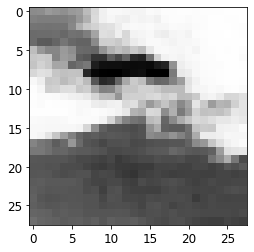

In [10]:
#Verify again by plotting the last processed image
plt.figure()
plt.imshow(image_bw, cmap='Greys')
print(image_bw.shape)

In [11]:
images_arr = np.stack(images)
images_arr_rsz = images_arr.reshape((len(images),-1))

In [12]:
#The data is shaped to represent each pictures through a list of 128*128 elements in grayscale
print(images_arr.shape)

(100000, 28, 28)


In [13]:
#let us now convert the dataframe into a panda structure to be able to use it with non convolutional network
df = pd.DataFrame(data=images_arr_rsz,
                  columns=['pixels_'+str(i+1) for i in range(images_arr_rsz.shape[1])])

In [14]:
# df['index'] = index
df

,pixels_1,pixels_2,pixels_3,pixels_4,pixels_5,pixels_6,pixels_7,pixels_8,pixels_9,pixels_10,...,pixels_775,pixels_776,pixels_777,pixels_778,pixels_779,pixels_780,pixels_781,pixels_782,pixels_783,pixels_784
0,62,61,67,55,80,97,99,101,103,103,...,131,122,112,91,73,61,140,77,78,76
1,118,141,216,250,252,254,254,252,229,251,...,107,107,108,105,104,96,89,117,111,86
2,214,221,230,238,244,244,243,245,248,250,...,115,110,114,110,80,74,86,68,46,27
3,24,57,100,149,106,88,123,59,33,36,...,20,21,21,21,22,21,21,21,22,24
4,128,129,129,128,128,128,128,128,128,127,...,105,106,110,108,107,109,112,115,115,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,216,213,224,247,250,252,254,251,253,254,...,93,100,102,94,87,95,96,96,89,86
99996,10,9,8,9,9,8,8,8,10,11,...,97,91,82,81,76,68,64,59,42,33
99997,246,241,174,140,93,67,45,33,31,22,...,46,56,74,61,58,49,62,83,96,78
99998,70,53,93,109,85,56,110,89,70,88,...,53,20,13,39,31,41,59,97,188,187


### Splitting the dataset as 0.8/0.2

In [15]:
index_arr = np.array(index)

In [16]:
index_arr = index_arr[:12000]

In [17]:
images_arr = images_arr[:12000]

In [18]:
images_arr.shape

(12000, 28, 28)

In [19]:
X_test, X_train_inventory, y_test, y_train_inventory = train_test_split(images_arr, index_arr, test_size=0.98, random_state=42, stratify=index_arr)

In [63]:
X_train_inventory.shape

(11760, 28, 28)

In [64]:
X_train, X_valid = X_train_inventory[:9000], X_train_inventory[9000:]
y_train, y_valid = y_train_inventory[:9000], y_train_inventory[9000:]

In [66]:
print(categories_dataset[y_train[205]])

amphitheater


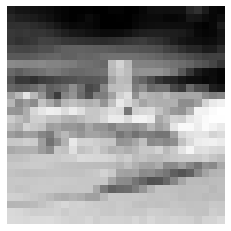

In [65]:
plt.imshow(X_train[205], cmap="binary")
plt.axis('off')
plt.show()

# Using the Multi Layer Perception

## Building the network

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # first layer convert each input image into a 1D array
model.add(keras.layers.Dense(512, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
model.add(keras.layers.Dense(512, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
#hidden layer with 100 neurons using the ReLU

model.add(keras.layers.Dense(100, activation="softmax")) #output layer with 100 neurons (one per class), using the softmax 

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 100)               51300     
                                                                 
Total params: 715,876
Trainable params: 715,876
Non-trainable params: 0
_________________________________________________________________


## Training the network

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train, y_train, batch_size=256, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
43/43 [==============================] - 3s 36ms/step - loss: 97.9393 - accuracy: 0.0982 - val_loss: 13.6031 - val_accuracy: 0.1211
Epoch 2/30
43/43 [==============================] - 1s 23ms/step - loss: 8.9958 - accuracy: 0.1235 - val_loss: 6.6410 - val_accuracy: 0.1395
Epoch 3/30
43/43 [==============================] - 1s 23ms/step - loss: 5.4997 - accuracy: 0.1281 - val_loss: 4.6528 - val_accuracy: 0.1105
Epoch 4/30
43/43 [==============================] - 1s 23ms/step - loss: 3.9117 - accuracy: 0.1395 - val_loss: 3.6709 - val_accuracy: 0.1513
Epoch 5/30
43/43 [==============================] - 1s 21ms/step - loss: 3.2045 - accuracy: 0.1487 - val_loss: 3.2662 - val_accuracy: 0.1329
Epoch 6/30
43/43 [==============================] - 1s 23ms/step - loss: 2.8614 - accuracy: 0.1674 - val_loss: 2.9370 - val_accuracy: 0.1382
Epoch 7/30
43/43 [==============================] - 1s 28ms/step - loss: 2.6396 - accuracy: 0.1747 - val_loss: 2.7667 - val_accuracy: 0.1539
Epoch 8/30


### Network training curve & evaluation

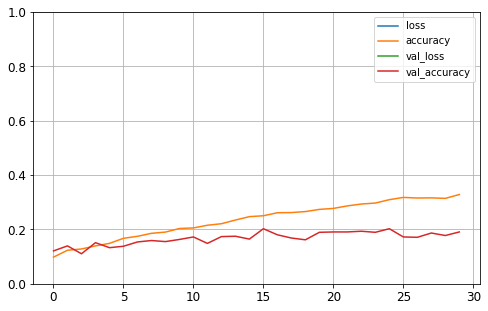

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [36]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 5ms/step - loss: 2.6084 - accuracy: 0.1708


[2.608372688293457, 0.17083333432674408]

# Using ANN and CNN

In [67]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(100, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [68]:
cnn = model2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
282/282 [==============================] - 13s 41ms/step - loss: 3.1616 - accuracy: 0.1399 - val_loss: 2.3094 - val_accuracy: 0.2043
Epoch 2/20
282/282 [==============================] - 11s 38ms/step - loss: 2.2671 - accuracy: 0.2191 - val_loss: 2.2297 - val_accuracy: 0.2449
Epoch 3/20
282/282 [==============================] - 11s 39ms/step - loss: 2.1825 - accuracy: 0.2546 - val_loss: 2.2398 - val_accuracy: 0.2395
Epoch 4/20
282/282 [==============================] - 11s 38ms/step - loss: 2.0935 - accuracy: 0.2838 - val_loss: 2.3093 - val_accuracy: 0.2496
Epoch 5/20
282/282 [==============================] - 11s 38ms/step - loss: 1.9950 - accuracy: 0.3266 - val_loss: 2.2017 - val_accuracy: 0.2533
Epoch 6/20
282/282 [==============================] - 11s 38ms/step - loss: 1.8829 - accuracy: 0.3680 - val_loss: 2.2223 - val_accuracy: 0.2783
Epoch 7/20
282/282 [==============================] - 11s 39ms/step - loss: 1.7825 - accuracy: 0.4032 - val_loss: 2.2917 - val_accuracy:

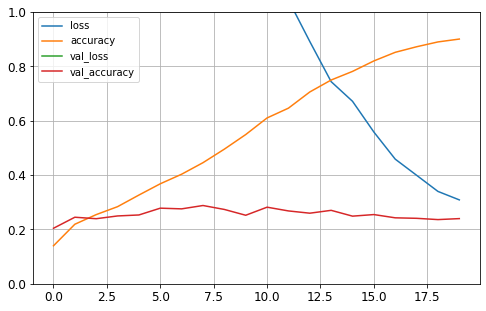

In [69]:
pd.DataFrame(cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [70]:
model2.evaluate(X_test, y_test)

8/8 [==============================] - 0s 11ms/step - loss: 6.7100 - accuracy: 0.2042


[6.710019111633301, 0.20416666567325592]